In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import datetime
from dateutil import parser
import matplotlib.dates as mdates
import matplotlib.ticker as plticker

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Conv1D, Input
from keras.layers import BatchNormalization

In [ ]:

from google.colab import drive
import numpy as np
import pandas as pd
# This will prompt for authorization.
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
ta_1 = ['sma_n50', 'roc_n100',
       'roc_n48', 'roc_n20', 'roc_n12', 'roc_n10', 'k_perc_d_n14',
        'k_perc_d_n36', 'k_perc_d_n24', 'k_perc_d_n48', 'smaps_n12',
       'cci_n14', 'smaps_n24',  'smaps_n30', 'cci_n24',
        'cci_n36', 'rsi_n14', 'rsi_n24', 'smaps_n50',
       'cci_n48', 'rsi_n36', 'rsi_n48', 'lwi_n14', 'k_perc_n14', 'lwi_n36',
       'k_perc_n36', 'smaps_n100', 'k_perc_n24', 'lwi_n24', 'lwi_n48',
       'k_perc_n48',  'smaps_n200',
       'volume']

ta_2 = ['sma_n12', 'ema_n12', 'sma_n24', 'sma_n30', 'ema_n24', 'ema_n30',
        'ema_n50', 'sma_n100', 'ema_n100', 'sma_n200', 'ema_n200']

ta_3 = ['macdss', 
       'smas_n200_m50']

b_1 = ['sum_transaction']
b_2 = ['no_blocks']
b_3 = [ 'mean_size', 'mean_transaction_count']

e_2 = ['eurousd', 'sp_index']

s_10 = ['polarity', 'counter', 'mean_neu']

s_10_13 = ['positive_ratio', 'negative_ratio', 'mean_comp',
       'mean_pos',
       'mean_neg']

s_13 = ['sum_pos_neg', 'no_negative',
       'no_positive', 
       'negative_positive_ratio']

In [ ]:
price = pd.read_csv('/content/drive/My Drive/Magisterka/dane_final/df_transformed_no_laged.csv')

In [ ]:
blockchain = pd.read_csv('/content/drive/My Drive/Magisterka/dane_final/data_blockchain_economic.csv')

In [ ]:
col_ta_l0 = ['date', 'open'] + list(price.columns[[i[-2:]=='l0' for i in price.columns]])

In [ ]:
price = price[col_ta_l0]

In [ ]:
price.columns = ['date', 'open'] + [i.replace('_l0', '') for i in price.columns[2:]]

In [ ]:
blockchain['date'] = pd.to_datetime(blockchain['date'], utc=True)
price['date'] = pd.to_datetime(price['date'], utc=True)

In [ ]:
df = price.merge(blockchain, how = 'left', right_on = 'date', left_on = 'date')

In [ ]:
df_new = df.iloc[1:].reset_index(drop = True)
df_new['y'] = ((df.open.iloc[1:].reset_index(drop = True) - df.open.iloc[0:df.shape[0]-1])>0).astype('int')
df_new = df_new[['y','open']+list(df.columns)]

In [ ]:
df_new = df_new[['date', 'y', 'open']+list(df_new.columns[3:])].fillna(0)

In [ ]:
df_new.to_csv('/content/drive/My Drive/Magisterka/dane_final/data_classifier.csv', index = False)

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Magisterka/dane_final/data_classifier.csv')

In [ ]:
df_21 = pd.read_csv('/content/drive/My Drive/Magisterka/dane_final/data_classifier_2021.csv')

wybiore tylko te zmienne, ktore zostaly wybrane metoda selekcji czyli ta_1, ta_2, e_2, b_3

In [ ]:
daty_test = df.date.iloc[20000:]

In [ ]:
daty = df_21.date

In [ ]:
df_open = df[['y','open'] + ta_1 + ta_2 + e_2 + b_3]
df = df[['y'] + ta_1 + ta_2 + e_2 + b_3]

In [ ]:
df_open_21 = df_21[['y','open'] + ta_1 + ta_2 + e_2 + b_3]
df_21 = df_21[['y'] + ta_1 + ta_2 + e_2 + b_3]

# LSTM
batch size
number of layers


In [ ]:
no_nodes = [30,50,70,90,100, 150,200]
batch_size = [8, 64, 128]
dropout = [0, 0.1]
look_backs = [1,3,6,9,12,18,24]
theta = [0, 0.1, 0.2]

In [ ]:
def get_keras_model(num_neurons_per_layer, 
                    dropout_rate, look_back,num_of_features):
    '''

  LSTM modeln with configuration defined by parameters
    '''
    model = Sequential()
    model.add(LSTM(num_neurons_per_layer, input_shape=(look_back,num_of_features), dropout = dropout_rate))
    model.add(Dense(1, activation='sigmoid'))


    model.compile(loss='binary_crossentropy', optimizer='adam',  metrics=[tf.keras.metrics.AUC()])

    

    return model


def get_keras_model_cnn(num_neurons_per_layer, 
                     look_back,num_of_features, filters, kernel, padding):
    '''
  CNN-LSTM model for configuration defined by parameters

    '''
    input_layer = Input(shape=(look_back,num_of_features))
    conv1 = Conv1D(filters=filters,
                  kernel_size=kernel,
                  strides=1,
                  activation='relu',
                  padding=padding)(input_layer)
    
    lstm1 = LSTM(num_neurons_per_layer)(conv1)
    #x   = BatchNormalization()(lstm1)
    output_layer = Dense(1, activation='sigmoid')(lstm1)
    model = Model(inputs=input_layer, outputs=output_layer)

    model.compile(loss='binary_crossentropy', optimizer='adam',  metrics=[tf.keras.metrics.AUC()])

    return model
    
def create_dataset(dataset, pred_col, look_back=1):

  '''
creation of datashape for given look_back

  '''
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back):
    a = dataset[i:(i+look_back), 1:]
    dataX.append(a)
    dataY.append(dataset[i + look_back, pred_col])
  return np.array(dataX), np.array(dataY)

def ret(model, testX, look_back, theta, df_open_, index_open):
  strategy = pd.DataFrame(columns = ['actual_price', 'prediction', 'btc_wallet', 'usd_wallet'])
  strategy['prediction']= model.predict(testX).reshape(-1)
  strategy['actual_price'] = df_open_.iloc[index_open+look_back-1:df_open_.shape[0]-1].open.reset_index(drop=True)
  strategy.btc_wallet = 0
  strategy.usd_wallet = 0
  strategy.usd_wallet[0] = 1000


  for i in range(1,strategy.shape[0]):
    if (strategy.prediction[i]>0.5+theta) and  (strategy.usd_wallet[i-1]>0): #buy
        strategy.btc_wallet.iloc[i] = strategy.usd_wallet[i-1]/strategy.actual_price[i]
        strategy.usd_wallet.iloc[i] = 0
    elif (strategy.prediction[i]<0.5-theta) and  (strategy.btc_wallet[i-1]>0): #sell
        strategy.btc_wallet.iloc[i] = 0
        strategy.usd_wallet.iloc[i] = strategy.actual_price[i]*strategy.btc_wallet[i-1]
    else: #hold
        strategy.btc_wallet.iloc[i] = strategy.btc_wallet[i-1]
        strategy.usd_wallet.iloc[i] = strategy.usd_wallet[i-1]

  if strategy.btc_wallet.iloc[-1] == 0:
    return strategy.usd_wallet.iloc[-1]/strategy.usd_wallet.iloc[0]
  else: 
    return strategy.btc_wallet.iloc[-1]/1000*strategy.actual_price.iloc[0]

In [ ]:

no_nodes = [30,70,90, 150]
batch_size = [8]
dropout = [0.1]
look_backs = [1,6,12,24]
theta = [0, 0.1, 0.2]
kernel = [4,8,16,24]
filters = [8,32,48]
padding = ['same', 'valid']

In [ ]:
results_cnn = pd.DataFrame(columns = [ 'batch_size', 'no_nodes', 'look_back', 'theta','kernel_size','filters', 'padding', 'acc', 'auc', 'return'])

In [ ]:
results = pd.DataFrame(columns = ['dropout', 'batch_size', 'no_nodes', 'look_back', 'theta', 'acc', 'auc', 'return'])

In [ ]:
lista_columns = ['dropout', 'batch_size', 'no_nodes', 'look_back']
for i in range(12):
  lista_columns.append('acc_'+str(i))
  lista_columns.append('auc_'+str(i))
lista_columns.append('theta')
for i in range(12):
  lista_columns.append('return_'+str(i))

In [ ]:
results = pd.DataFrame(columns = lista_columns)

In [ ]:
values = df.values
values_21 = df_21.values
pred_col = df.columns.get_loc('y')
num_of_features = df.shape[1]-1
values = values.astype('float32')
values_21 = values_21.astype('float32')
train = values[:18000, :]
val = values[18000:20000, :]
test = values[20000:, :]
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(train)

train = scaler.transform(train)
val = scaler.transform(val)
test = scaler.transform(test)
values_21 = scaler.transform(values_21)

lista_testowych = []
for i in range(11):
  lista_testowych.append(values_21[i*2000:(i+1)*2000])

for drop in dropout:
  for batch in batch_size:
    for nodes in no_nodes:
      for look_back in look_backs:
        #if [drop, batch, nodes, look_back] not in used_params:
        trainX, trainY = create_dataset(train, pred_col, look_back=look_back)
        testX, testY = create_dataset(test, pred_col, look_back=look_back)
        valX, valY = create_dataset(val, pred_col, look_back=look_back)
      
        trainX = np.reshape(trainX, (trainX.shape[0], look_back, num_of_features))
        testX = np.reshape(testX, (testX.shape[0],look_back, num_of_features))
        valX = np.reshape(valX, (valX.shape[0],look_back, num_of_features))
        
        model = get_keras_model(nodes, drop, look_back, num_of_features)
        history = model.fit(trainX, trainY, epochs = 20, batch_size = batch, validation_data=(valX, valY), verbose=2, shuffle=False)
        
        
        auc = model.evaluate(testX, testY, verbose=0)[1]
        acc = np.mean(((model.predict(testX).reshape(-1)>0.5).astype('int')==testY).astype('int'))

        param = [drop, batch, nodes, look_back, acc, auc]

        testowe_created = [create_dataset(i, pred_col, look_back=look_back) for i in lista_testowych]

        for para_testowa in testowe_created:
          param.append(model.evaluate(para_testowa[0], para_testowa[1], verbose=0)[1])
          param.append(np.mean(((model.predict(para_testowa[0]).reshape(-1)>0.5).astype('int')==para_testowa[1]).astype('int')))

          
        for thet in theta:
          param_thet = []
          param_thet.append(thet)
          returny = ret(model, testX, look_back, thet, df_open, 20000)
          
          param_thet.append(returny)

          for i in range(len(testowe_created)):
            param_thet.append(ret(model, testowe_created[i][0], look_back, thet, df_open_21, 2000*i))

          results = results.append(pd.DataFrame(param+param_thet, index = results.columns).transpose())

          results.to_csv('/content/drive/My Drive/Magisterka/dane_final/results_final_21_2.csv', index = False)




In [ ]:
values = df.values
pred_col = df.columns.get_loc('y')
num_of_features = df.shape[1]-1
values = values.astype('float32')
train = values[:18000, :]
val = values[18000:20000, :]
test = values[20000:, :]
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(train)
# frame as supervised learning
train = scaler.transform(train)
val = scaler.transform(val)
test = scaler.transform(test)


i = 0
for batch in batch_size:
  for nodes in no_nodes:
    for look_back in look_backs:
      for kernel_size in kernel:
        for filter in filters:
          for padding_type in padding:
            if [batch, nodes, look_back, kernel_size, filter, padding_type] not in used_params:
              try:
                trainX, trainY = create_dataset(train, pred_col, look_back=look_back)
                testX, testY = create_dataset(test, pred_col, look_back=look_back)
                valX, valY = create_dataset(val, pred_col, look_back=look_back)
                # reshape input to be  [samples, time steps, features]
                trainX = np.reshape(trainX, (trainX.shape[0], look_back, num_of_features))
                testX = np.reshape(testX, (testX.shape[0],look_back, num_of_features))
                valX = np.reshape(valX, (valX.shape[0],look_back, num_of_features))
                
                model = get_keras_model_cnn(nodes, 
                        look_back,num_of_features, filter, kernel_size, padding_type)
                history = model.fit(trainX, trainY, epochs = 20, batch_size = batch, validation_data=(valX, valY), verbose=2, shuffle=False)
                

                auc = model.evaluate(testX, testY, verbose=0)
                acc = np.mean(((model.predict(testX).reshape(-1)>0.5).astype('int')==testY).astype('int'))


                for thet in theta:

                  returny = ret(model, testX, look_back, thet)
                  
                  param = [batch, nodes, look_back, thet,kernel_size, filter, padding_type, acc, auc[1], returny]

                  results_cnn = results_cnn.append(pd.DataFrame(param, index = results_cnn.columns).transpose())

                  results_cnn.to_csv('/content/drive/My Drive/Magisterka/dane_final/results_final_cnn_no_normalization.csv', index = False)
              except:
                i = i+1
                print(i)



Number of parameters

In [ ]:
parametry_lstm = pd.DataFrame(columns = ['dropout','batch','nodes', 'look_back', 'number_param' ])

In [ ]:
for drop in dropout:
  for batch in batch_size:
    for nodes in no_nodes:
      for look_back in look_backs:
        
        
        model = get_keras_model(nodes, drop, look_back, num_of_features)
        
        param = [drop, batch, nodes, look_back]

        param.append(model.count_params())

        parametry_lstm = parametry_lstm.append(pd.DataFrame(param, index = parametry_lstm.columns).transpose())

        

In [ ]:
parametry_lstm.to_csv('/content/drive/My Drive/Magisterka/dane_final/parametry_lstm.csv', index = False)

In [ ]:
print(parametry_lstm[['nodes',  'number_param']].drop_duplicates().to_latex(index=False))

\begin{tabular}{ll}
\toprule
nodes & number\_param \\
\midrule
   30 &         9511 \\
   50 &        19851 \\
   70 &        33391 \\
   90 &        50131 \\
  100 &        59701 \\
  150 &       119551 \\
  200 &       199401 \\
\bottomrule
\end{tabular}



In [ ]:
params_cnn = pd.DataFrame(columns = ['batch', 'nodes', 'look_back', 'kernel_size', 'filter', 'padding_type', 'no_params'])

In [ ]:
for batch in batch_size:
  for nodes in no_nodes:
    for look_back in look_backs:
      for kernel_size in kernel:
        for filter in filters:
          for padding_type in padding:
            try:
              
              model = get_keras_model_cnn(nodes, 
                      look_back,num_of_features, filter, kernel_size, padding_type)
              
                
              param = [batch, nodes, look_back, kernel_size, filter, padding_type,model.count_params()]

              params_cnn = params_cnn.append(pd.DataFrame(param, index = params_cnn.columns).transpose())
            except:
              pass


In [ ]:
params_cnn.to_csv('/content/drive/My Drive/Magisterka/dane_final/parametry_cnn.csv', index = False)

In [ ]:
filters

[8, 32, 48]

In [ ]:
unikalne = params_cnn[['nodes',  'kernel_size', 'filter',
       'no_params']].drop_duplicates()

In [ ]:
print(pd.concat([unikalne[unikalne['filter'] == 8][['nodes', 'kernel_size', 'no_params']].reset_index(drop=True),unikalne[unikalne['filter'] == 32][['nodes', 'kernel_size', 'no_params']].reset_index(drop=True),unikalne[unikalne['filter'] == 48][['nodes', 'kernel_size', 'no_params']].reset_index(drop=True)],1
          ).to_latex(index=False))

\begin{tabular}{lllllllll}
\toprule
nodes & kernel\_size & no\_params & nodes & kernel\_size & no\_params & nodes & kernel\_size & no\_params \\
\midrule
   30 &           4 &      6255 &    30 &           4 &     13767 &    30 &           4 &     18775 \\
   30 &           8 &      7791 &    30 &           8 &     19911 &    30 &           8 &     27991 \\
   30 &          16 &     10863 &    30 &          16 &     32199 &    30 &          16 &     46423 \\
   30 &          24 &     13935 &    30 &          24 &     44487 &    30 &          24 &     64855 \\
   70 &           4 &     23735 &    70 &           4 &     35087 &    70 &           4 &     42655 \\
   70 &           8 &     25271 &    70 &           8 &     41231 &    70 &           8 &     51871 \\
   70 &          16 &     28343 &    70 &          16 &     53519 &    70 &          16 &     70303 \\
   70 &          24 &     31415 &    70 &          24 &     65807 &    70 &          24 &     88735 \\
   90 &           4 & 

# Final model

In [ ]:
import pandas as pd

In [ ]:
results = pd.read_csv('/content/drive/My Drive/Magisterka/dane_final/results_final.csv')

In [ ]:
results.iloc[105:108,:]

,dropout,batch_size,no_nodes,look_back,theta,acc,auc,return
105,0.0,8.0,100.0,24.0,0.0,0.948857,0.982155,43.488572
106,0.0,8.0,100.0,24.0,0.1,0.948857,0.982155,43.060581
107,0.0,8.0,100.0,24.0,0.2,0.948857,0.982155,42.459175


In [ ]:
drop=        0
batch=     8
nodes=      100
look_back=      24

In [ ]:
values = df.values
values_21 = df_21.values
pred_col = df.columns.get_loc('y')
num_of_features = df.shape[1]-1
values = values.astype('float32')

train = values[:18000, :]
val = values[18000:20000, :]
test = values[20000:, :]
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(train)
# frame as supervised learning
train = scaler.transform(train)
val = scaler.transform(val)
test = scaler.transform(test)

trainX, trainY = create_dataset(train, pred_col, look_back=look_back)
testX, testY = create_dataset(test, pred_col, look_back=look_back)
valX, valY = create_dataset(val, pred_col, look_back=look_back)
# reshape input to be  [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, num_of_features))
testX = np.reshape(testX, (testX.shape[0],look_back, num_of_features))
valX = np.reshape(valX, (valX.shape[0],look_back, num_of_features))

model = get_keras_model(nodes, drop, look_back, num_of_features)
history = model.fit(trainX, trainY, epochs = 20, batch_size = batch, validation_data=(valX, valY), verbose=2, shuffle=False)


auc = model.evaluate(testX, testY, verbose=0)[1]
acc = np.mean(((model.predict(testX).reshape(-1)>0.5).astype('int')==testY).astype('int'))

In [ ]:
model.count_params()

59701

In [ ]:
wallets = []
for  theta in [0,0.1,0.2]: 
  df_open_ = df_open
  index_open=20000
  strategy = pd.DataFrame(columns = ['actual_price', 'prediction', 'btc_wallet', 'usd_wallet'])
  strategy['prediction']= model.predict(testX).reshape(-1)
  strategy['actual_price'] = df_open_.iloc[index_open+look_back-1:df_open_.shape[0]-1].open.reset_index(drop=True)
  
  strategy.btc_wallet = 0
  strategy.usd_wallet = 0
  strategy.usd_wallet[0] = 1000


  for i in range(1,strategy.shape[0]):
    if (strategy.prediction[i]>0.5+theta) and  (strategy.usd_wallet[i-1]>0): #buy
        strategy.btc_wallet.iloc[i] = strategy.usd_wallet[i-1]/strategy.actual_price[i]
        strategy.usd_wallet.iloc[i] = 0
    elif (strategy.prediction[i]<0.5-theta) and  (strategy.btc_wallet[i-1]>0): #sell
        strategy.btc_wallet.iloc[i] = 0
        strategy.usd_wallet.iloc[i] = strategy.actual_price[i]*strategy.btc_wallet[i-1]
    else: #hold
        strategy.btc_wallet.iloc[i] = strategy.btc_wallet[i-1]
        strategy.usd_wallet.iloc[i] = strategy.usd_wallet[i-1]

  wallets.append(strategy)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
for i in wallets:
  i['date'] = pd.to_datetime(daty_test.reset_index(drop=True).iloc[24:].reset_index(drop=True))
  for j in range(i.shape[0]):
    if i.usd_wallet.iloc[j]==0:
      i.usd_wallet.iloc[j] = i.btc_wallet.iloc[j]*i.actual_price.iloc[j]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
wallet_theta0 = wallets[0]
wallet_theta0['y_predicted'] = (wallet_theta0['prediction']>0.5).astype('int')

In [ ]:
diffe = ((wallet_theta0.actual_price.iloc[1:].reset_index(drop = True)-wallet_theta0.actual_price.iloc[0:wallet_theta0.shape[0]-1])>0).astype('int')

In [ ]:
wallet_theta0 = wallet_theta0.iloc[1:,:].reset_index(drop=True)

In [ ]:
wallet_theta0['y_actual'] = diffe[1:].reset_index(drop=True)

In [ ]:
wallet_theta0 = wallet_theta0.iloc[0:1836]

In [ ]:
wallet_theta0['cena_wlasciwa'] = wallet_theta0.actual_price.iloc[1:].reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
wallet_theta0 = wallet_theta0.iloc[0:1835]

In [ ]:
diffe = (wallet_theta0.cena_wlasciwa.iloc[1:].reset_index(drop = True)-wallet_theta0.cena_wlasciwa.iloc[0:wallet_theta0.shape[0]-1])

In [ ]:
wallet_theta0 = wallet_theta0.iloc[1:,:].reset_index(drop=True)

In [ ]:
wallet_theta0['roznica'] = diffe.reset_index(drop=True)

In [ ]:
wallet_theta0

,actual_price,prediction,btc_wallet,usd_wallet,date,y_predicted,y_actual,cena_wlasciwa,roznica
0,3843.59,0.999952,0.260173,1000.000000,2019-03-07 12:00:00+00:00,1,1.0,3851.29,7.70
1,3851.29,0.999997,0.260173,1002.003335,2019-03-07 13:00:00+00:00,1,1.0,3859.88,8.59
2,3859.88,0.075925,0.000000,1004.238225,2019-03-07 14:00:00+00:00,0,0.0,3857.88,-2.00
3,3857.88,1.000000,0.260308,1004.238225,2019-03-07 15:00:00+00:00,1,1.0,3875.53,17.65
4,3875.53,0.000518,0.000000,1008.832667,2019-03-07 16:00:00+00:00,0,0.0,3865.00,-10.53
...,...,...,...,...,...,...,...,...,...
1828,7884.07,1.000000,5.309239,41858.412924,2019-05-22 16:00:00+00:00,1,1.0,7982.02,97.95
1829,7982.02,0.000165,0.000000,42378.452896,2019-05-22 17:00:00+00:00,0,0.0,7951.72,-30.30
1830,7951.72,0.000040,0.000000,42378.452896,2019-05-22 18:00:00+00:00,0,0.0,7907.76,-43.96
1831,7907.76,0.984786,5.359097,42378.452896,2019-05-22 19:00:00+00:00,1,1.0,7929.14,21.38


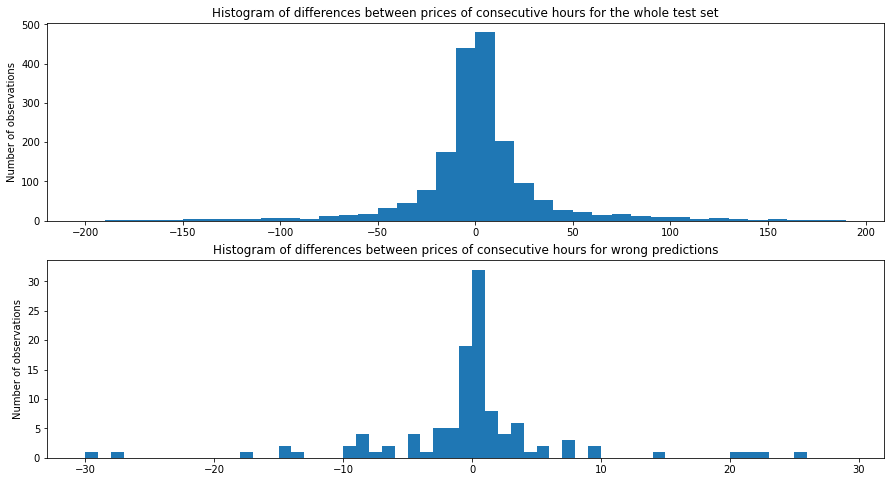

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(15, 8), sharex=False)
kolory = {12: 'purple', 50:'red', 200:'green'}


ax[0].hist(
      wallet_theta0.roznica, bins = list(range(-200,200,10)))


ax[0].set(
       ylabel="Number of observations",
       title="Histogram of differences between prices of consecutive hours for the whole test set")

ax[1].hist(
      wallet_theta0.roznica[wallet_theta0.y_actual!=wallet_theta0.y_predicted], bins = list(range(-30,30,1)))


ax[1].set(
       ylabel="Number of observations",
       title="Histogram of differences between prices of consecutive hours for wrong predictions")


sciezka = '/content/drive/My Drive/Magisterka/wykresy/'
plt.savefig(sciezka+'histogram_of_differences.png', dpi=300, bbox_inches='tight')

plt.show()

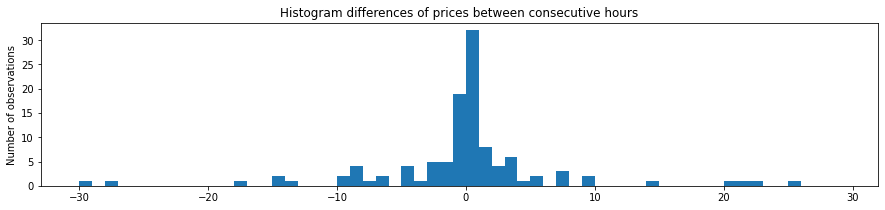

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 3), sharex=False)
kolory = {12: 'purple', 50:'red', 200:'green'}


ax.hist(
      wallet_theta0.roznica[wallet_theta0.y_actual!=wallet_theta0.y_predicted], bins = list(range(-30,30,1)))


ax.set(
       ylabel="Number of observations",
       title="Histogram of differences between prices of consecutive hours for wrong predictions")


sciezka = '/content/drive/My Drive/Magisterka/wykresy/'
#plt.savefig(sciezka+'test_set_wrong_predictions.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
np.mean(wallet_theta0.roznica[wallet_theta0.y_actual!=wallet_theta0.y_predicted])

-0.20508928571428392

In [ ]:
np.sum(wallet_theta0.y_predicted==wallet_theta0.y_actual)

817

In [ ]:
testY

array([0., 0., 0., ..., 1., 0., 0.], dtype=float32)

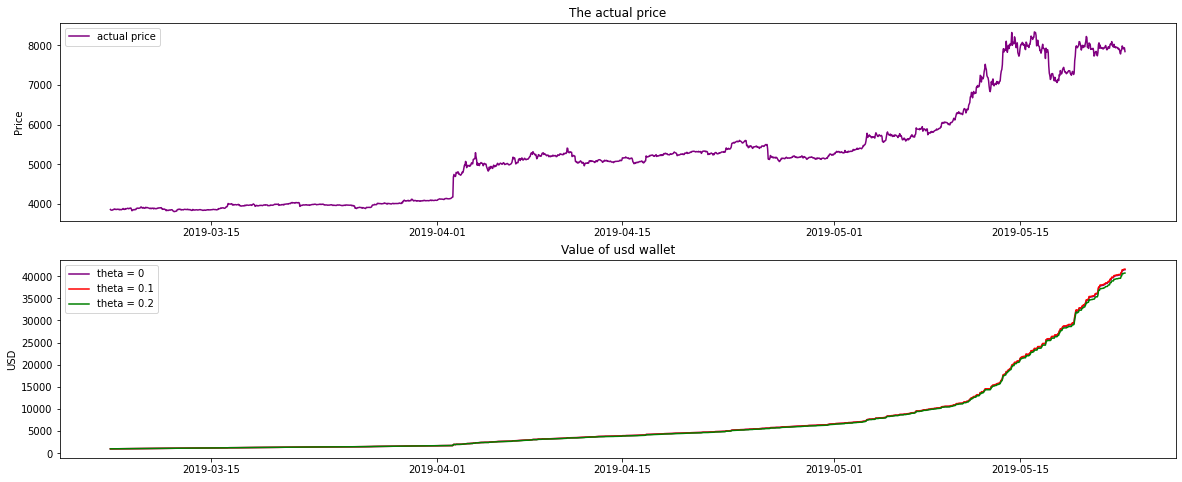

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1,figsize=(20, 12), sharex=False)
kolory = {12: 'purple', 50:'red', 200:'green'}

# Add x-axis and y-axis
ax[0].plot(list(wallets[0]['date']),
      list(wallets[0].actual_price),
      color=kolory[12], label='actual price')


ax[0].legend()

# Set title and labels for axes
ax[0].set(
       ylabel="Price",
       title="The actual price")

# Add x-axis and y-axis
ax[2].hist(
      list(wallets[0].prediction), bins = [i/20 for i in list(range(0,21,1))])



# Add x-axis and y-axis



# Set title and labels for axes
ax[2].set(
       ylabel="Prediction",
       title="Model's prediction")



ax[1].plot(list(wallets[0]['date']),
      list(wallets[0].usd_wallet),
      color=kolory[12], label = 'theta = 0')



# Add x-axis and y-axis
ax[1].plot(list(wallets[0]['date']),
      list(wallets[1].usd_wallet),
      color=kolory[50], label = 'theta = 0.1')

ax[1].plot(list(wallets[0]['date']),
      list(wallets[2].usd_wallet),
      color=kolory[200], label = 'theta = 0.2')

ax[1].legend()

# Set title and labels for axes
ax[1].set(
       ylabel="USD",
       title="Value of usd wallet")




sciezka = '/content/drive/My Drive/Magisterka/wykresy/'
plt.savefig(sciezka+'test_set_simulation.png', dpi=300, bbox_inches='tight')

plt.show()

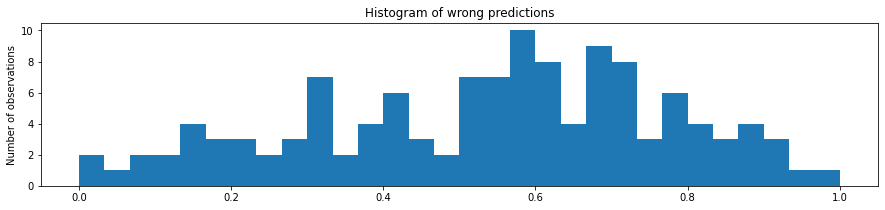

In [ ]:
 fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 3), sharex=False)
kolory = {12: 'purple', 50:'red', 200:'green'}

# Add x-axis and y-axis

# Add x-axis and y-axis
ax.hist(
      model.predict(testX)[np.where(((model.predict(testX).reshape(-1)>0.5).astype('int')==testY).astype('int')==0)], bins = [i/30 for i in list(range(0,31,1))])



# Add x-axis and y-axis



# Set title and labels for axes
ax.set(
       ylabel="Number of observations",
       title="Histogram of wrong predictions")


sciezka = '/content/drive/My Drive/Magisterka/wykresy/'
plt.savefig(sciezka+'test_set_wrong_predictions.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(testX)
preds = probs
fpr, tpr, threshold = metrics.roc_curve(testY, preds)
roc_auc = metrics.auc(fpr, tpr)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(testY, (model.predict(testX)>0.5).astype('int').reshape(-1))

array([[802,  62],
       [ 40, 934]])

# Symulacje

zbadanie skutecznosci dla nowszych danych i ekstremalnych sytuacji

  - 12.02.20 - 12.03.20 - spadki zwiazane z covidem
  - 14.01.20 - 14.02.20 - sredni wzrost
  - 11.05.19 - 25.06.19 - duzy wzrost
  - 22.06.20 - 22.07.20 - stagnacja
  - 08.12.20 - 08.01.21 - ekstremalne wzrosty 
  - 27.06.20 - 27.07.20 - stagnacja
  - 26.11.19 - 26.12.19 - stagnacja
  - 05.08.20 - 05.09.20 - sredni spadek
  - 26.10.19 - 26.11.19 - spadek


In [ ]:
spadki = [['2020-02-12','2020-03-13'], ['2020-08-05','2020-09-06'], ['2019-10-26','2019-11-27']]
wzrosty = [['2020-01-14','2020-02-15'],['2019-05-26','2019-06-27'],['2020-12-08','2021-01-09']]
stagnacja = [['2020-06-22','2020-07-23'],['2019-11-26','2019-12-27'],['2020-06-27','2020-07-21']]

In [ ]:
daty = spadki+wzrosty+stagnacja

In [ ]:
daty

[['2020-02-12', '2020-03-13'],
 ['2020-08-05', '2020-09-06'],
 ['2019-10-26', '2019-11-27'],
 ['2020-01-14', '2020-02-15'],
 ['2019-05-26', '2019-06-27'],
 ['2020-12-08', '2021-01-09'],
 ['2020-06-22', '2020-07-23'],
 ['2019-11-26', '2019-12-27'],
 ['2020-06-27', '2020-07-21']]

In [ ]:
spadki_df = []
for i in daty:
  spadki_df.append([df_21[(df_21.date>=i[0])&(df_21.date<=i[1])].index[0],df_21[(df_21.date>=i[0])&(df_21.date<=i[1])].index[-1]])

In [ ]:
spadki_df = [[9009, 9728],
 [13209, 13976],
 [6393, 7160],
 [8313, 9080],
 [2721, 3488],
 [16208, 16971],
 [12153, 12896],
 [7137, 7880],
 [12273, 12848]]

In [ ]:
nazwy = []
for i in daty:
  nazwy.append(i[0]+' - '+i[1])

In [ ]:
nazwy

['2020-02-12 - 2020-03-13',
 '2020-08-05 - 2020-09-06',
 '2019-10-26 - 2019-11-27',
 '2020-01-14 - 2020-02-15',
 '2019-05-26 - 2019-06-27',
 '2020-12-08 - 2021-01-09',
 '2020-06-22 - 2020-07-23',
 '2019-11-26 - 2019-12-27',
 '2020-06-27 - 2020-07-21']

In [ ]:
wyniki = pd.DataFrame(columns = nazwy)

In [ ]:
wyniki

,2020-02-12 - 2020-03-13,2020-08-05 - 2020-09-06,2019-10-26 - 2019-11-27,2020-01-14 - 2020-02-15,2019-05-26 - 2019-06-27,2020-12-08 - 2021-01-09,2020-06-22 - 2020-07-23,2019-11-26 - 2019-12-27,2020-06-27 - 2020-07-21


In [ ]:
indeksy = ['start price', 'end price', '(end price)/(start price)', 'number of 1', 'number of 0', '(number of 1)/(number of 0)','auc', 'acc', 'return', 'actual return']

In [ ]:
zbiory = []
zbiory_open = []
for i in spadki_df:
  zbiory.append(df_21.iloc[i[0]:i[1]])
  zbiory_open.append(df_open_21.iloc[i[0]:i[1]])

In [ ]:
i = 0
zbiory[i].y.value_counts()[1], zbiory[i].y.value_counts[0],zbiory[i].y.value_counts[1]/zbiory[i].y.value_counts[0], wyniki_spadki_wzrosty_auc[i],wyniki_spadki_wzrosty_acc[i], wyniki_spadki_wzrosty_return_0[i], wyniki_spadki_wzrosty_return_0[i]]

0.5676078050841821

In [ ]:
for i in range(len(zbiory)):
  wyniki[nazwy[i]] = [zbiory_open[i].open.iloc[0],zbiory_open[i].open.iloc[-1],stosunek_koniec_poczatek[i],zbiory[i].y.value_counts()[1], zbiory[i].y.value_counts()[0],zbiory[i].y.value_counts()[1]/zbiory[i].y.value_counts()[0], wyniki_spadki_wzrosty_auc[i],wyniki_spadki_wzrosty_acc[i],wyniki_spadki_wzrosty_return_0[i], wyniki_spadki_wzrosty_return_0[i]/stosunek_koniec_poczatek[i]]
 

In [ ]:
wyniki

,2020-02-12 - 2020-03-13,2020-08-05 - 2020-09-06,2019-10-26 - 2019-11-27,2020-01-14 - 2020-02-15,2019-05-26 - 2019-06-27,2020-12-08 - 2021-01-09,2020-06-22 - 2020-07-23,2019-11-26 - 2019-12-27,2020-06-27 - 2020-07-21
0,10223.080000,11191.990000,8655.020000,8110.340000,8025.410000,19166.900000,9294.690000,7109.570000,9162.210000
1,5819.970000,10081.950000,7106.950000,10329.810000,12596.680000,40075.820000,9374.250000,7199.890000,9167.480000
2,0.567608,0.891933,0.824692,1.275656,1.626104,2.121993,1.022089,1.012642,1.000283
3,355.000000,369.000000,374.000000,403.000000,411.000000,427.000000,374.000000,369.000000,284.000000
4,364.000000,398.000000,393.000000,364.000000,356.000000,336.000000,369.000000,374.000000,291.000000
5,0.975275,0.927136,0.951654,1.107143,1.154494,1.270833,1.013550,0.986631,0.975945
6,0.981572,0.981506,0.981422,0.981342,0.981292,0.981173,0.981049,0.980978,0.980909
7,0.874820,0.897712,0.872140,0.880215,0.884253,0.806495,0.869263,0.878999,0.856624
8,5.434451,2.973599,3.674587,3.297479,6.655646,5.002054,1.827105,3.206795,1.476997
9,9.574306,3.333884,4.455706,2.584929,4.093002,2.357244,1.787619,3.166760,1.476579


In [ ]:
wyniki.index = indeksy

In [ ]:
spadki = wyniki.iloc[:,0:3]

In [ ]:
wzrosty = wyniki.iloc[:,3:6]

In [ ]:
stagnacja = wyniki.iloc[:,6:]

In [ ]:
print(wzrosty.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  2020-01-14 - 2020-02-15 &  2019-05-26 - 2019-06-27 &  2020-12-08 - 2021-01-09 \\
\midrule
start price                 &              8110.340000 &              8025.410000 &             19166.900000 \\
end price                   &             10329.810000 &             12596.680000 &             40075.820000 \\
(end price)/(start price)   &                 1.275656 &                 1.626104 &                 2.121993 \\
number of 1                 &               403.000000 &               411.000000 &               427.000000 \\
number of 0                 &               364.000000 &               356.000000 &               336.000000 \\
(number of 1)/(number of 0) &                 1.107143 &                 1.154494 &                 1.270833 \\
auc                         &                 0.981342 &                 0.981292 &                 0.981173 \\
acc                         &                 0.880215 &                 0.884253 &      

In [ ]:
print(spadki.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  2020-02-12 - 2020-03-13 &  2020-08-05 - 2020-09-06 &  2019-10-26 - 2019-11-27 \\
\midrule
start price                 &             10223.080000 &             11191.990000 &              8655.020000 \\
end price                   &              5819.970000 &             10081.950000 &              7106.950000 \\
(end price)/(start price)   &                 0.567608 &                 0.891933 &                 0.824692 \\
number of 1                 &               355.000000 &               369.000000 &               374.000000 \\
number of 0                 &               364.000000 &               398.000000 &               393.000000 \\
(number of 1)/(number of 0) &                 0.975275 &                 0.927136 &                 0.951654 \\
auc                         &                 0.981572 &                 0.981506 &                 0.981422 \\
acc                         &                 0.874820 &                 0.897712 &      

In [ ]:
stosunek_koniec_poczatek = []
for i in spadki_df:
  stosunek_koniec_poczatek.append(df_21.open.iloc[i[1]]/df_21.open.iloc[i[0]])

In [ ]:
stosunek_koniec_poczatek = [0.5676078050841821,
 0.8919325338925428,
 0.8246924906008304,
 1.2756555212235245,
 1.6261038376855512,
 2.1219926018291946,
 1.022088956167446,
 1.0126421147833131,
 1.0002826828898268]

In [ ]:
def simulations_generate(test_data,df_open, index_open, look_back,daty):
  wallets = []
  for  theta in [0,0.1,0.2]: 
    df_open_ = df_open
    strategy = pd.DataFrame(columns = ['actual_price', 'prediction', 'btc_wallet', 'usd_wallet'])
    strategy['prediction']= model.predict(test_data).reshape(-1)
    strategy['actual_price'] = df_open_.iloc[index_open+look_back-1:df_open_.shape[0]-1].open.reset_index(drop=True)
    strategy.btc_wallet = 0
    strategy.usd_wallet = 0
    strategy.usd_wallet[0] = 1000


    for i in range(1,strategy.shape[0]):
      if (strategy.prediction[i]>0.5+theta) and  (strategy.usd_wallet[i-1]>0): #buy
          strategy.btc_wallet.iloc[i] = strategy.usd_wallet[i-1]/strategy.actual_price[i]
          strategy.usd_wallet.iloc[i] = 0
      elif (strategy.prediction[i]<0.5-theta) and  (strategy.btc_wallet[i-1]>0): #sell
          strategy.btc_wallet.iloc[i] = 0
          strategy.usd_wallet.iloc[i] = strategy.actual_price[i]*strategy.btc_wallet[i-1]
      else: #hold
          strategy.btc_wallet.iloc[i] = strategy.btc_wallet[i-1]
          strategy.usd_wallet.iloc[i] = strategy.usd_wallet[i-1]

    wallets.append(strategy)

  for i in wallets:
    i['date'] = pd.to_datetime(daty.iloc[index_open+look_back:].reset_index(drop=True))
    for j in range(i.shape[0]):
      if i.usd_wallet.iloc[j]==0:
        i.usd_wallet.iloc[j] = i.btc_wallet.iloc[j]*i.actual_price.iloc[j]
  return wallets

In [ ]:
def wykres_symulacja(wallets, nazwa):
  fig, ax = plt.subplots(nrows=3, ncols=1,figsize=(20, 12), sharex=False)
  kolory = {12: 'purple', 50:'red', 200:'green'}

  # Add x-axis and y-axis
  ax[0].plot(list(wallets[0]['date']),
        list(wallets[0].actual_price),
        color=kolory[12], label='actual price')


  ax[0].legend()

  # Set title and labels for axes
  ax[0].set(
        ylabel="Price",
        title="The actual price")

  # Add x-axis and y-axis
  ax[2].hist(
        list(wallets[0].prediction), bins = [i/20 for i in list(range(0,21,1))])



  # Add x-axis and y-axis



  # Set title and labels for axes
  ax[2].set(
        ylabel="Prediction",
        title="Model's prediction")



  ax[1].plot(list(wallets[0]['date']),
        list(wallets[0].usd_wallet),
        color=kolory[12], label = 'theta = 0')



  # Add x-axis and y-axis
  ax[1].plot(list(wallets[0]['date']),
        list(wallets[1].usd_wallet),
        color=kolory[50], label = 'theta = 0.1')

  ax[1].plot(list(wallets[0]['date']),
        list(wallets[2].usd_wallet),
        color=kolory[200], label = 'theta = 0.2')

  ax[1].legend()

  # Set title and labels for axes
  ax[1].set(
        ylabel="USD",
        title="Value of usd wallet")




  sciezka = '/content/drive/My Drive/Magisterka/wykresy/'
  plt.savefig(sciezka+nazwa+'.png', dpi=300, bbox_inches='tight')

  plt.show()


def wykres_zla_predykcja(testX, testY, nazwa):
  fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 3), sharex=False)
  kolory = {12: 'purple', 50:'red', 200:'green'}

  # Add x-axis and y-axis

  # Add x-axis and y-axis
  ax.hist(
        model.predict(testX)[np.where(((model.predict(testX).reshape(-1)>0.5).astype('int')==testY).astype('int')==0)], bins = [i/30 for i in list(range(0,31,1))])



  # Add x-axis and y-axis



  # Set title and labels for axes
  ax.set(
        ylabel="Number of observations",
        title="Histogram of wrong predictions")


  sciezka = '/content/drive/My Drive/Magisterka/wykresy/'
  plt.savefig(sciezka+nazwa+'.png', dpi=300, bbox_inches='tight')

  plt.show()

In [ ]:
values_21 = df_21.values
values_21 = values_21.astype('float32')
values_21 = scaler.transform(values_21)

lista_testowych = []
for i in spadki_df:
  lista_testowych.append(values_21[i[0]:i[1]])


testowe_created = [create_dataset(i, pred_col, look_back=look_back) for i in lista_testowych]

In [ ]:
df_open_21

,y,open,sma_n50,roc_n100,roc_n48,roc_n20,roc_n12,roc_n10,k_perc_d_n14,k_perc_d_n36,k_perc_d_n24,k_perc_d_n48,smaps_n12,cci_n14,smaps_n24,smaps_n30,cci_n24,cci_n36,rsi_n14,rsi_n24,smaps_n50,cci_n48,rsi_n36,rsi_n48,lwi_n14,k_perc_n14,lwi_n36,k_perc_n36,smaps_n100,k_perc_n24,lwi_n24,lwi_n48,k_perc_n48,smaps_n200,volume,sma_n12,ema_n12,sma_n24,sma_n30,ema_n24,ema_n30,ema_n50,sma_n100,ema_n100,sma_n200,ema_n200,eurousd,sp_index,mean_size,mean_transaction_count
0,0,3467.00,3446.8452,1.034260,-0.028580,0.836857,1.302326,1.263520,-3.761053,-0.497592,-3.761053,-3.367424,-31.576667,81.476473,-32.927917,-32.399333,123.770329,100.459219,77.995247,57.866191,-20.1548,60.003222,49.675187,49.959265,-22.047551,78.461734,-21.548223,78.451777,-35.7938,78.461734,-21.538266,-29.750000,70.250000,26.50425,779.980000,3435.423333,3424.261268,3434.072083,3434.600667,3432.989932,3437.216225,3452.218292,3431.2062,3425.777532,3493.50425,3523.631151,1.14759,2714.92,1.262962e+06,2591.250000
1,0,3463.02,3447.0304,1.056955,-0.036142,0.284554,1.214050,0.882975,-12.492637,-11.197407,-11.811990,-10.575758,-23.367500,56.272131,-27.364583,-27.618667,92.427244,83.051971,72.355995,59.157722,-15.9896,44.465264,48.491277,49.923731,-32.404629,70.533974,-28.794416,71.205584,-31.4984,71.214621,-28.785379,-36.238636,63.761364,30.13520,728.310000,3439.652500,3427.623152,3435.655417,3435.401333,3432.552939,3434.406582,3453.385997,3431.5216,3425.282482,3493.15520,3523.427519,1.14684,2710.49,1.220509e+06,2751.833333
2,0,3457.31,3447.1144,0.935553,-0.161877,0.524414,1.174919,1.168411,-6.078459,-3.113367,-3.113762,-2.787879,-13.947500,61.302762,-20.552083,-21.293333,100.270959,105.206908,72.475668,59.539348,-10.1956,61.526538,48.850496,49.322251,-28.989709,71.424489,-25.393401,74.606599,-25.4339,74.616068,-25.383932,-33.193182,66.806818,35.42865,861.640000,3443.362500,3430.784964,3436.757917,3436.016667,3433.282045,3434.015481,3453.240483,3431.8761,3425.162024,3492.73865,3523.178283,1.14729,2707.91,1.264908e+06,3025.750000
3,1,3459.99,3447.0116,1.342966,0.066576,0.765023,1.311915,0.989825,14.959707,15.105753,15.107670,13.526515,-13.171667,74.520878,-21.977500,-22.919667,114.592848,136.489902,77.607964,63.544110,-12.9784,86.328565,49.923691,50.405047,-11.808227,88.433106,-10.139594,89.860406,-27.7523,89.871811,-10.128189,-19.534091,80.465909,32.29100,668.210000,3446.818333,3433.926374,3438.012500,3437.070333,3433.253272,3433.415626,3453.003539,3432.2377,3425.205261,3492.28100,3522.807181,1.14685,2707.16,1.213554e+06,2026.833333
4,1,3472.01,3446.9312,1.592370,0.455364,1.177019,1.593261,1.161111,5.369763,5.912516,5.902546,12.973485,-21.843333,100.806124,-32.677083,-33.867000,132.868870,178.032292,77.270847,61.982919,-25.0788,117.855503,49.737339,52.262346,-17.833047,82.166953,-15.529954,84.470046,-39.4516,84.470046,-15.529954,-16.681818,83.318182,19.83155,1396.560000,3450.166667,3438.247489,3439.332917,3438.143000,3434.184607,3434.290243,3452.602966,3432.5584,3425.407183,3491.84155,3522.407389,1.14600,2701.09,1.291146e+06,2655.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19411,1,56254.98,55872.3070,-6.563927,2.579202,0.581810,3.973254,3.066689,9.903601,14.351478,13.456983,14.351478,-839.416667,117.755550,-823.504167,-683.188000,126.529947,76.642856,61.206795,55.793842,-382.6730,61.173978,50.527672,53.877381,-6.070613,93.929387,-22.740150,77.259850,1572.8316,93.929387,-6.070613,-22.740150,77.259850,3790.73670,3592.814650,55415.563333,55081.448382,55431.475833,55571.792000,55347.790902,55794.252565,55951.967976,57827.8116,59205.714272,60045.71670,61100.499766,1.20303,4131.02,1.339884e+06,2367.000000
19412,1,56572.44,55894.6954,-7.397779,2.255369,1.306293,2.724922,1.460386,1.466193,11.731259,3.600506,11.731259,-956.991667,136.088323,-1081.464583,-1009.570333,137.409626,99.893695,72.567717,55.314432,-677.7446,79.072136,48

In [ ]:
wyniki_spadki_wzrosty_return_0 = []
wyniki_spadki_wzrosty_return_01 = []
wyniki_spadki_wzrosty_return_02 = []
wyniki_spadki_wzrosty_auc = []
wyniki_spadki_wzrosty_acc = []

In [ ]:
for i in range(len(spadki_df)):
  wyniki_spadki_wzrosty_return_0.append(ret(model, testowe_created[i][0], look_back, 0, df_open_21, spadki_df[i][0]))
  wyniki_spadki_wzrosty_return_01.append(ret(model, testowe_created[i][0], look_back, 0.1, df_open_21, spadki_df[i][0]))
  wyniki_spadki_wzrosty_return_02.append(ret(model, testowe_created[i][0], look_back, 0.2, df_open_21, spadki_df[i][0]))
 
  wyniki_spadki_wzrosty_auc.append(model.evaluate(testowe_created[i][0], testowe_created[i][1], verbose=0)[1])
  wyniki_spadki_wzrosty_acc.append(np.mean(((model.predict(testowe_created[i][0]).reshape(-1)>0.5).astype('int')==testowe_created[i][1]).astype('int')))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
wyniki_spadki_wzrosty_return_0

[5.5098798058265475,
 2.9765667759387253,
 3.9166666952492935,
 3.3738422428950052,
 6.994506223077698,
 6.260719634143158,
 1.8552983460409078,
 3.2709138464711045,
 1.4983522312766646]

In [ ]:
wyniki_spadki_wzrosty_return_01

[5.479267061373675,
 2.9750635461369,
 3.8822738103394463,
 3.362981501844713,
 6.951070819422668,
 6.092976863652623,
 1.861279031567833,
 3.2912631926655047,
 1.4959829964976714]

In [ ]:
wyniki_spadki_wzrosty_return_02

[5.2000627822904795,
 2.9533995802853634,
 3.859354146119146,
 3.330907702312449,
 6.809268834931651,
 5.7448476371235255,
 1.8551514378341034,
 3.265263688326027,
 1.4902238740097988]

In [ ]:
wyniki_spadki_wzrosty_auc

[0.9814034104347229,
 0.9813713431358337,
 0.9813258647918701,
 0.9812962412834167,
 0.9812737107276917,
 0.9812074303627014,
 0.9811498522758484,
 0.9811104536056519,
 0.9810770750045776]

In [ ]:
wyniki_spadki_wzrosty_acc

[0.9165467625899281,
 0.917900403768506,
 0.9192462987886945,
 0.9111709286675639,
 0.9111709286675639,
 0.8633288227334236,
 0.9012517385257302,
 0.8998609179415855,
 0.8929219600725953]

In [ ]:
wallets_spadek1 = simulations_generate(testowe_created[0][0],df_open_21, spadki_df[0][0], look_back, daty)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


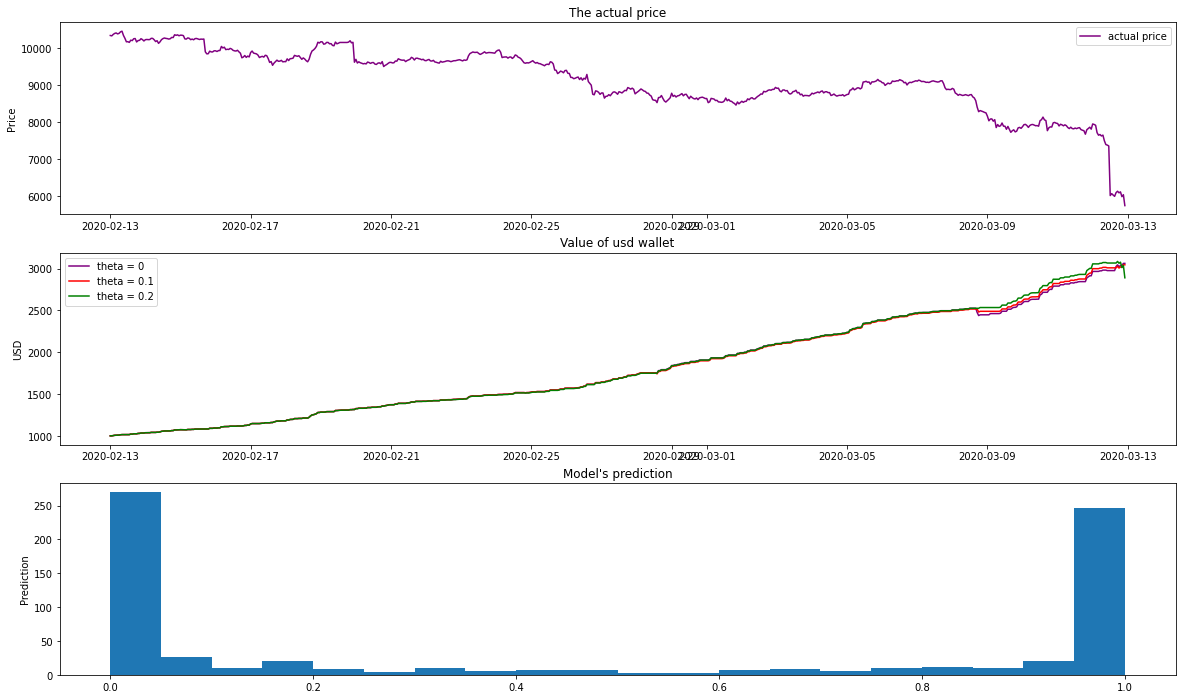

In [ ]:
wykres_symulacja(wallets_spadek1,'spadek1')

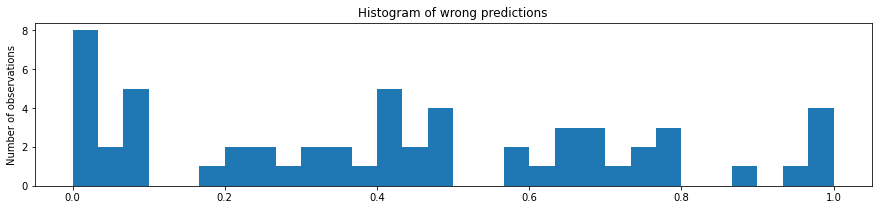

In [ ]:
wykres_zla_predykcja(testowe_created[0][0], testowe_created[0][1], 'histogram_spadek1')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


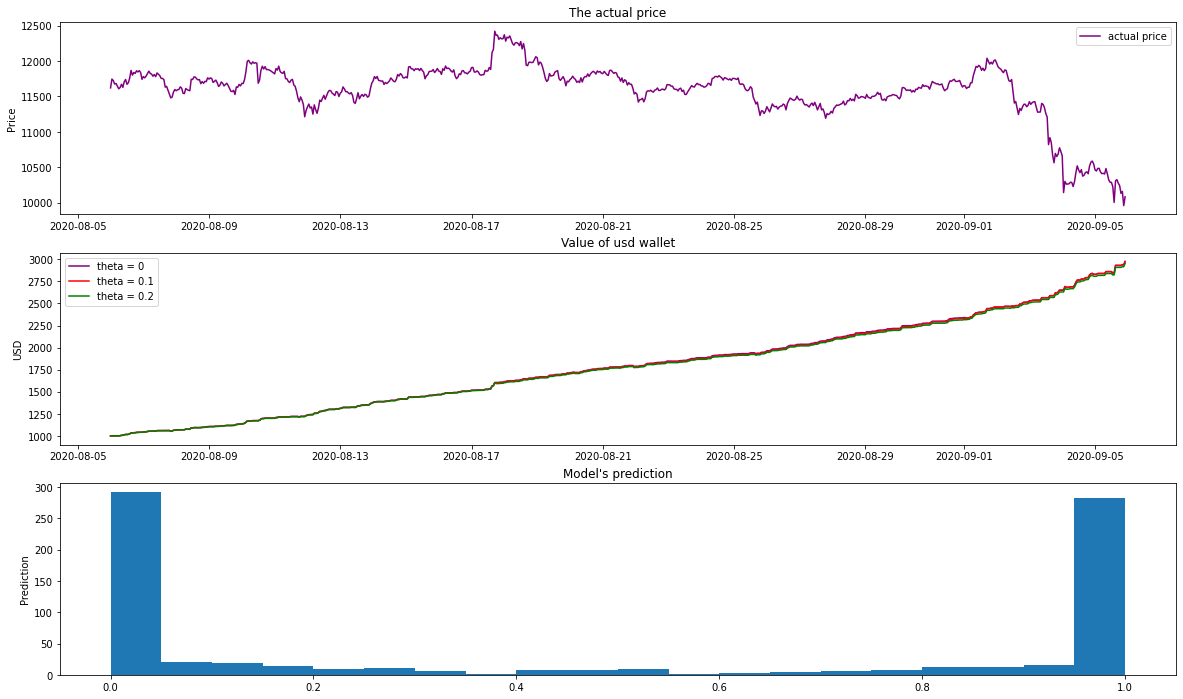

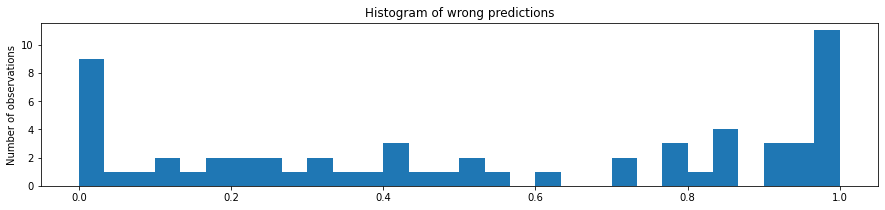

In [ ]:
wallets_spadek2 = simulations_generate(testowe_created[1][0],df_open_21, spadki_df[1][0], look_back, daty)
wykres_symulacja(wallets_spadek2,'spadek2')
wykres_zla_predykcja(testowe_created[1][0], testowe_created[1][1], 'histogram_spadek2')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


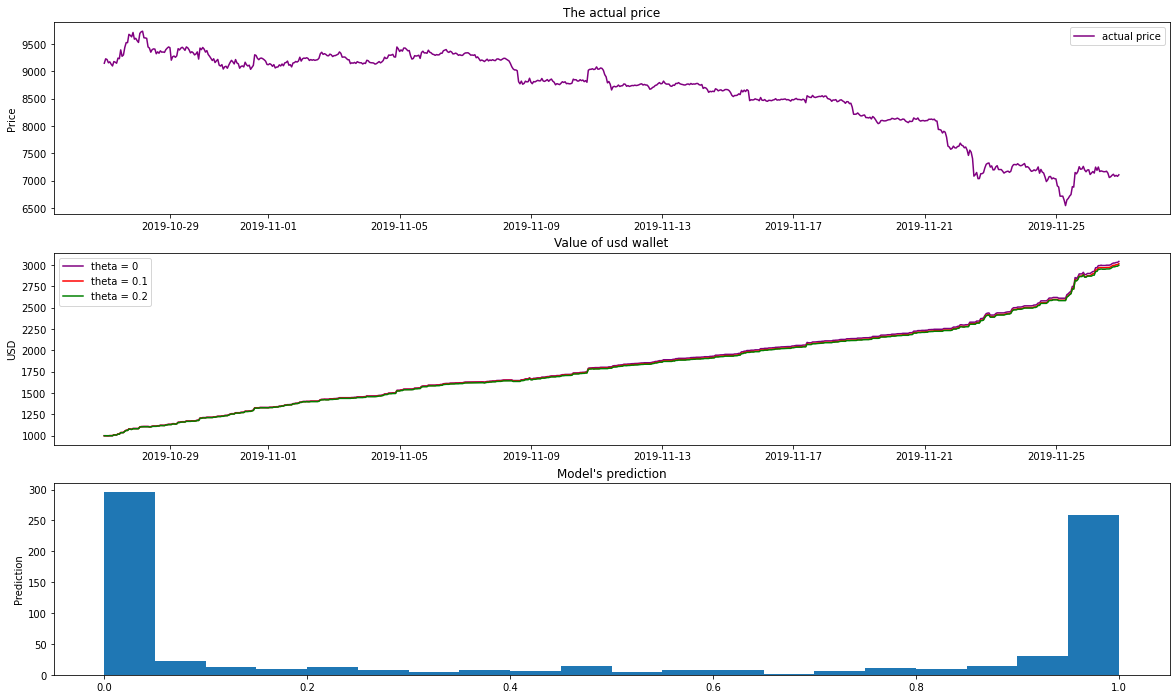

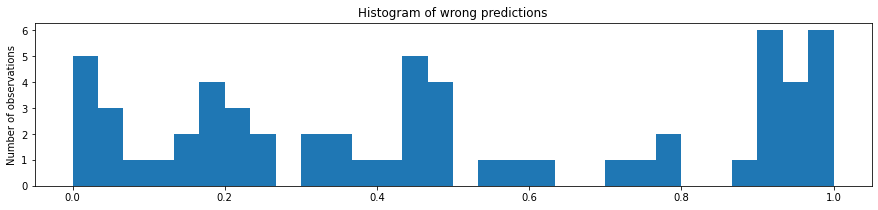

In [ ]:
wallets_spadek3 = simulations_generate(testowe_created[2][0],df_open_21, spadki_df[2][0], look_back, daty)
wykres_symulacja(wallets_spadek3,'spadek3')
wykres_zla_predykcja(testowe_created[2][0], testowe_created[2][1], 'histogram_spadek3')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


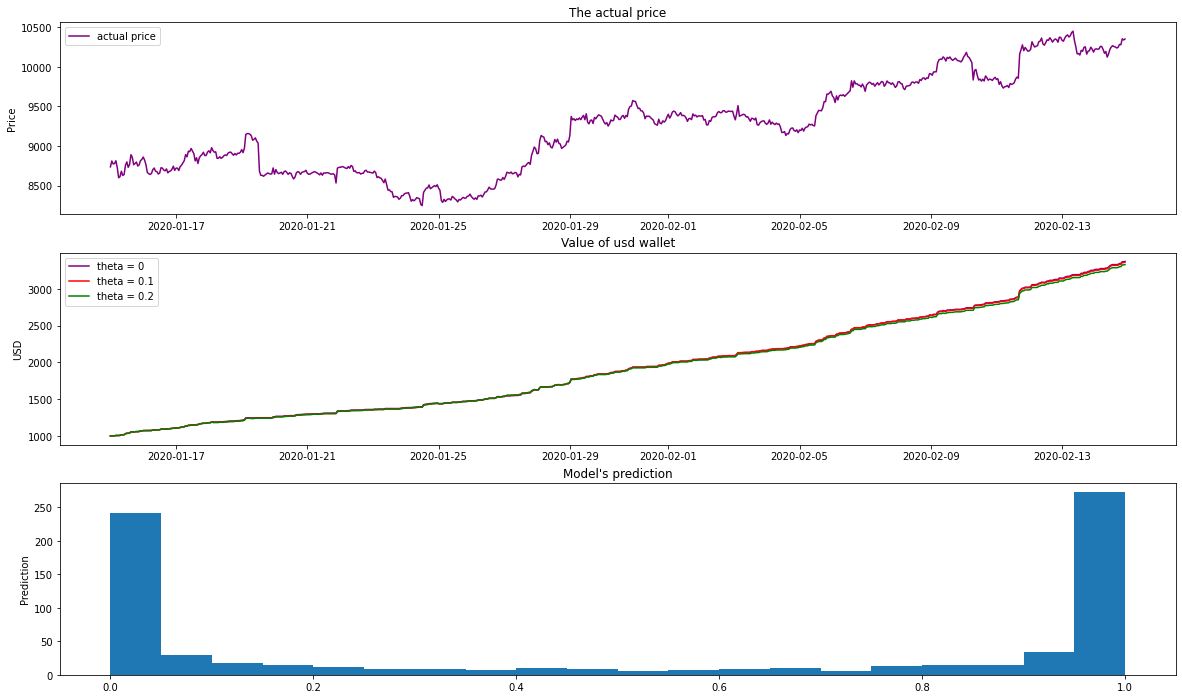

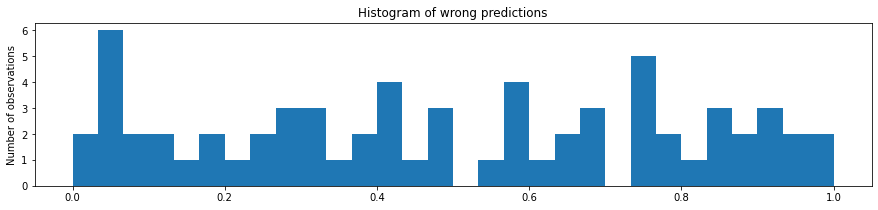

In [ ]:
wallets_wzrost1 = simulations_generate(testowe_created[3][0],df_open_21, spadki_df[3][0], look_back, daty)
wykres_symulacja(wallets_wzrost1,'wzrost1')
wykres_zla_predykcja(testowe_created[3][0], testowe_created[3][1], 'histogram_wzrost1')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


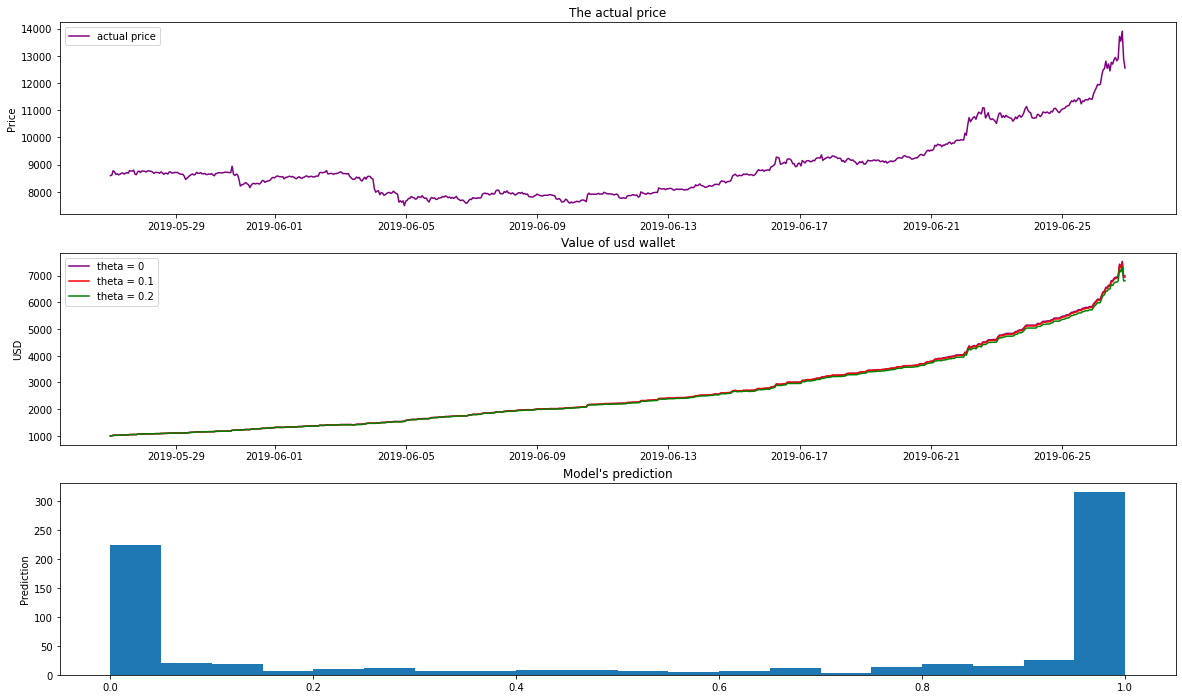

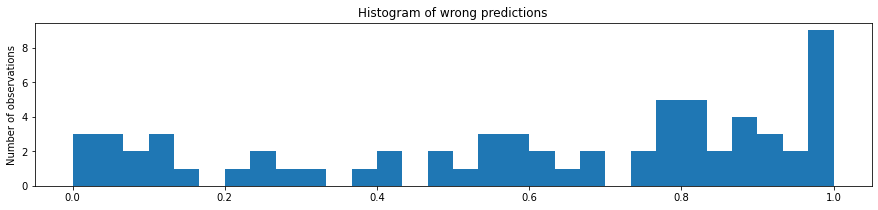

In [ ]:
wallets_wzrost2 = simulations_generate(testowe_created[4][0],df_open_21, spadki_df[4][0], look_back, daty)
wykres_symulacja(wallets_wzrost2,'wzrost2')
wykres_zla_predykcja(testowe_created[4][0], testowe_created[4][1], 'histogram_wzrost2')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


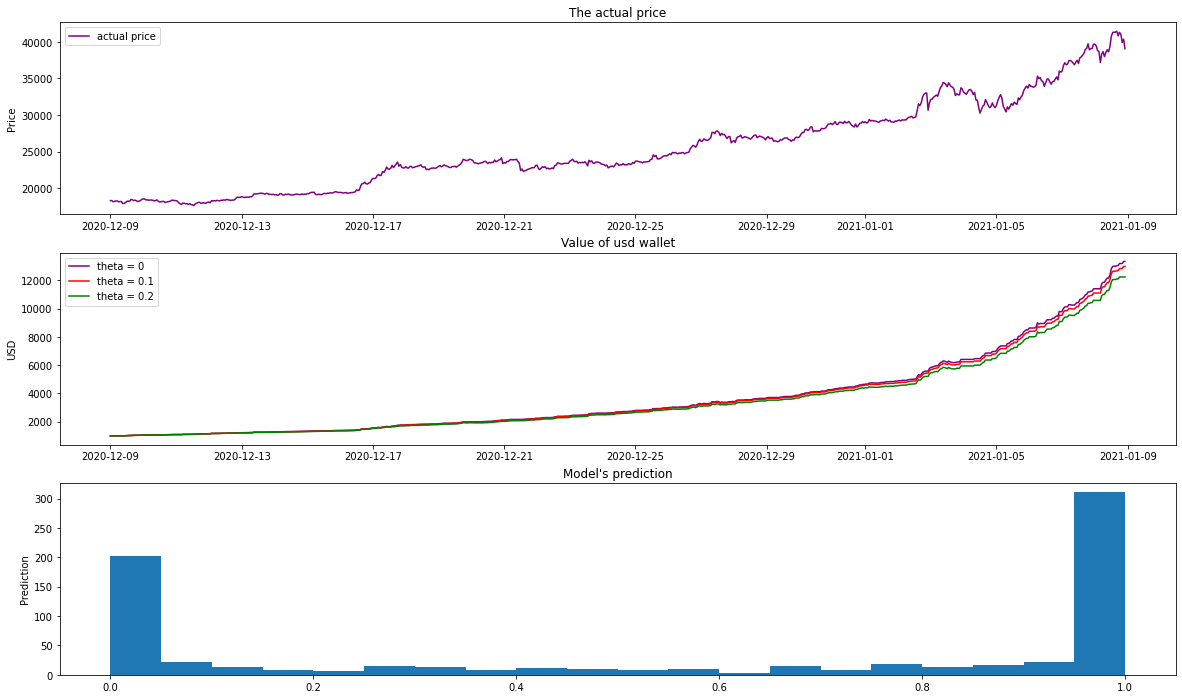

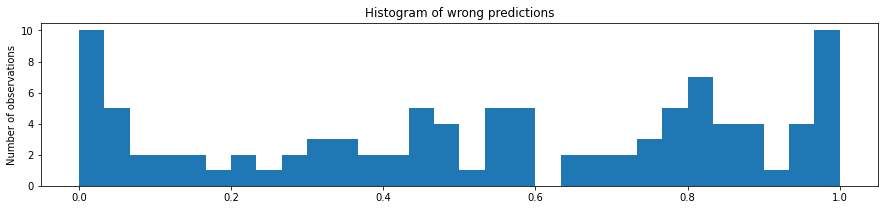

In [ ]:
wallets_wzrost3 = simulations_generate(testowe_created[5][0],df_open_21, spadki_df[5][0], look_back, daty)
wykres_symulacja(wallets_wzrost3,'wzrost3')
wykres_zla_predykcja(testowe_created[5][0], testowe_created[5][1], 'histogram_wzrost3')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


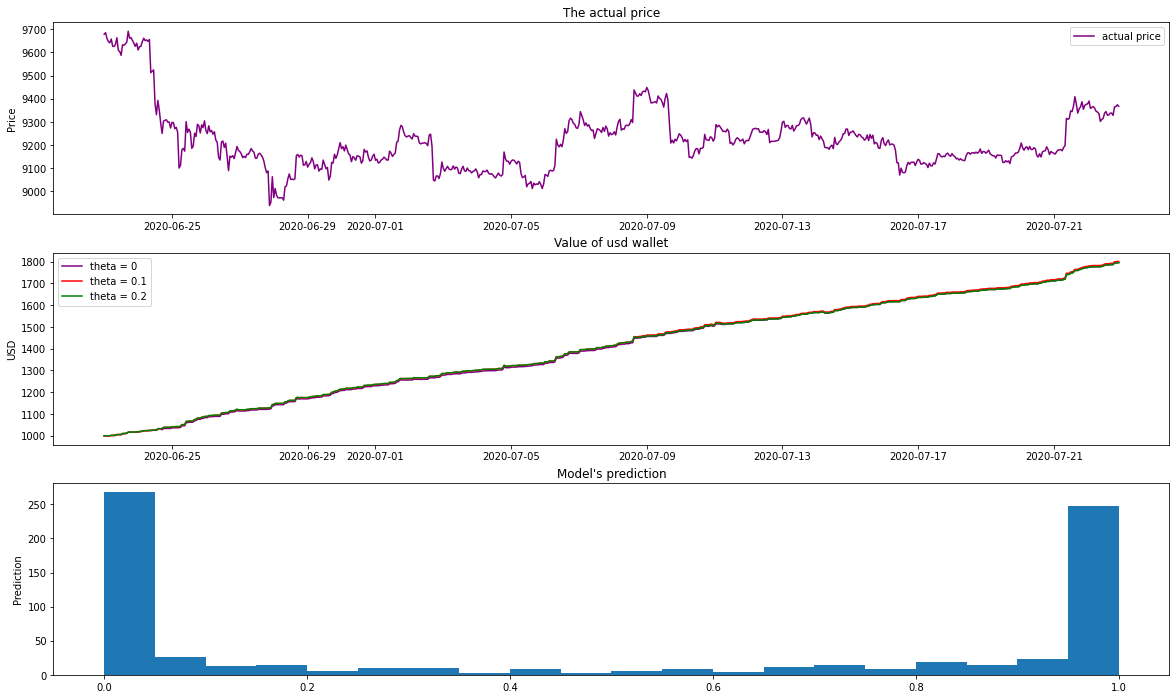

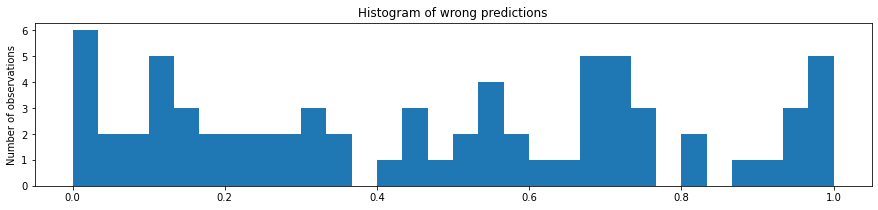

In [ ]:
wallets_stagnacja1 = simulations_generate(testowe_created[6][0],df_open_21, spadki_df[6][0], look_back, daty)
wykres_symulacja(wallets_stagnacja1,'stagnacja1')
wykres_zla_predykcja(testowe_created[6][0], testowe_created[6][1], 'histogram_stagnacja1')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


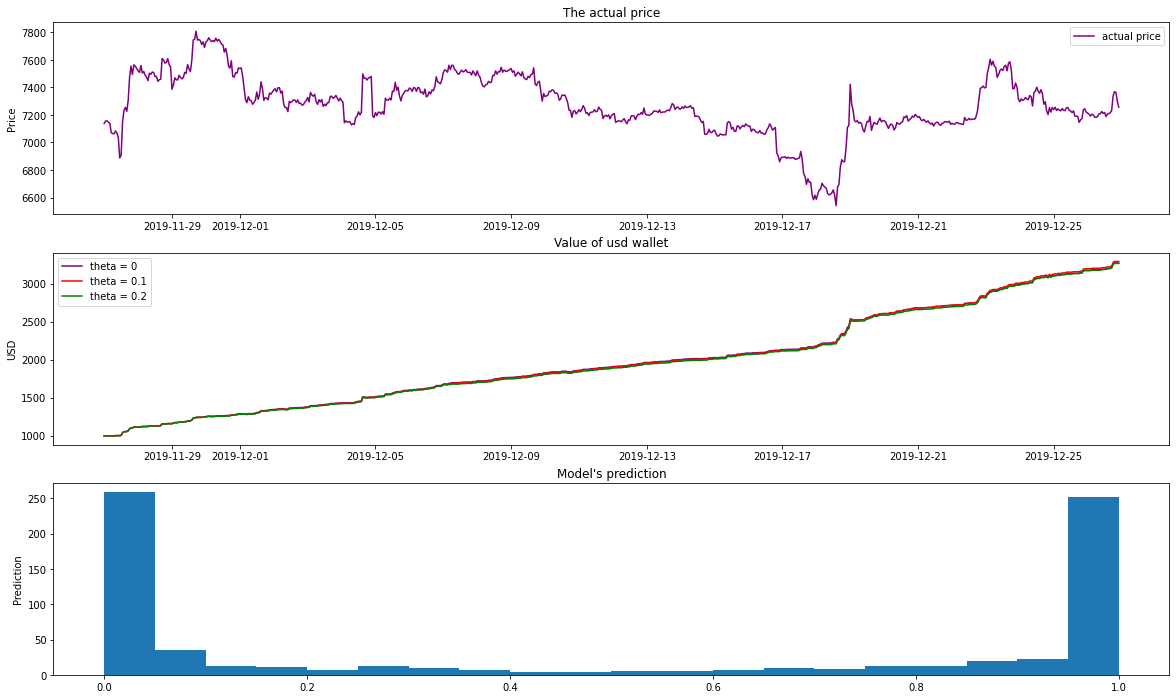

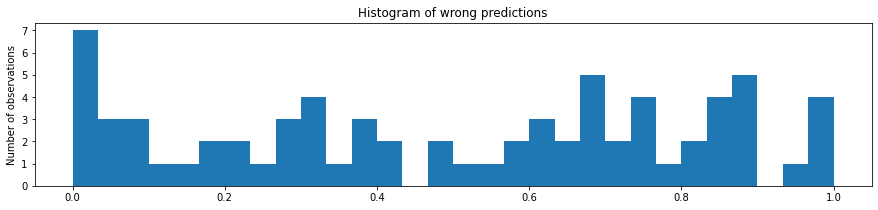

In [ ]:
wallets_stagnacja2 = simulations_generate(testowe_created[7][0],df_open_21, spadki_df[7][0], look_back, daty)
wykres_symulacja(wallets_stagnacja2,'stagnacja2')
wykres_zla_predykcja(testowe_created[7][0], testowe_created[7][1], 'histogram_stagnacja2')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


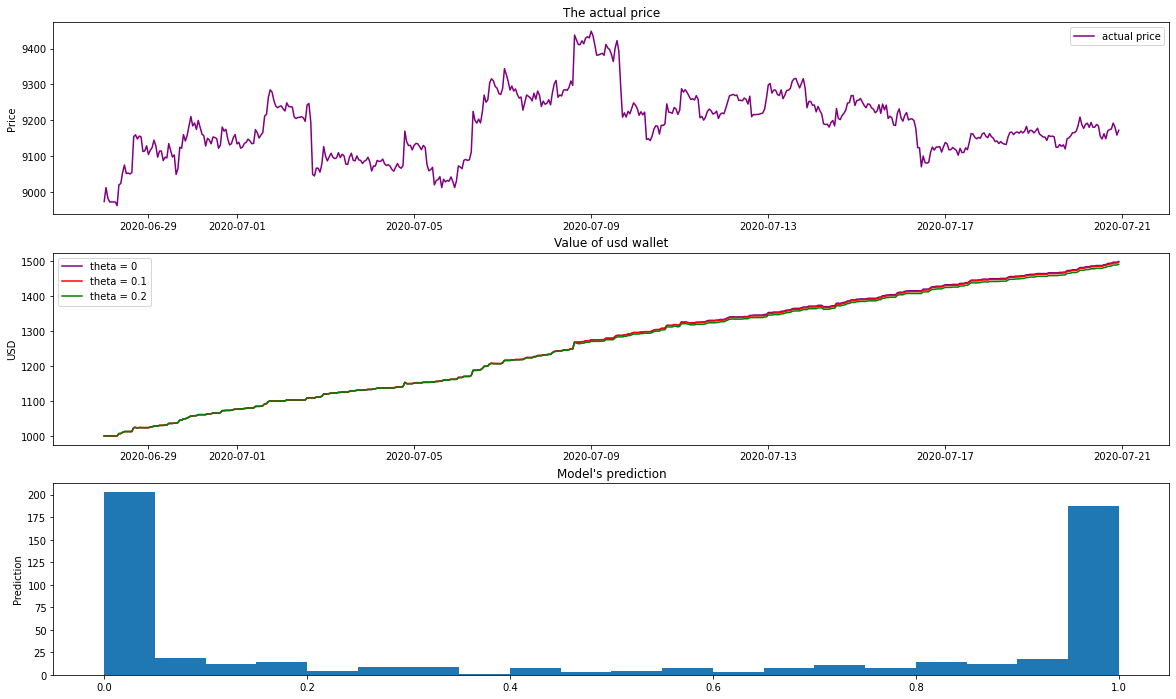

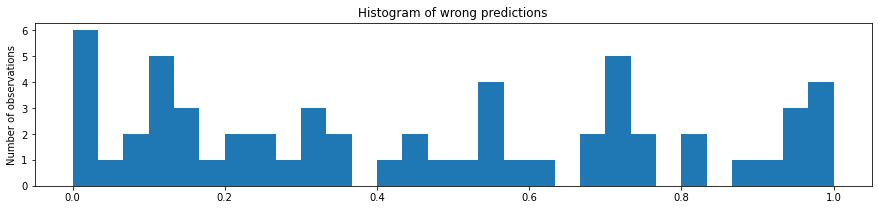

In [ ]:
wallets_stagnacja3 = simulations_generate(testowe_created[8][0],df_open_21, spadki_df[8][0], look_back, daty)
wykres_symulacja(wallets_stagnacja3,'stagnacja3')
wykres_zla_predykcja(testowe_created[8][0], testowe_created[8][1], 'histogram_stagnacja3')

In [ ]:
confusion = pd.DataFrame([[802,  62],
[ 40, 934]])

In [ ]:
confusion.columns = ['Predicted:\n 0', 'Predicted:\n 0']
confusion.index = ['Predicted:\n 0', 'Predicted:\n 0']

In [ ]:
print(confusion.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  Predicted:\textbackslash n 0 &  Predicted:\textbackslash n 0 \\
\midrule
Predicted:\textbackslash n 0 &             802 &              62 \\
Predicted:\textbackslash n 0 &              40 &             934 \\
\bottomrule
\end{tabular}



In [ ]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
data_wykres = pd.DataFrame(columns = ['date', 'y'])

In [ ]:
data_wykres['date'] = df.date.apply(lambda x: x.replace(hour=0))
data_wykres['y'] = df['y']

In [ ]:
data_wykres = data_wykres.groupby('date').sum().reset_index()

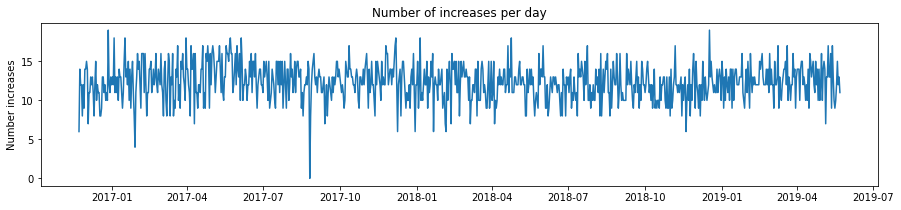

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 3), sharex=False)
kolory = {12: 'purple', 50:'red', 200:'green'}

ax.plot(data_wykres.date, data_wykres.y)


ax.set(
      ylabel="Number increases",
      title="Number of increases per day")


sciezka = '/content/drive/My Drive/Magisterka/wykresy/'
plt.savefig(sciezka+'price_increasements.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
results = pd.read_csv('/content/drive/My Drive/Magisterka/dane_final/results_final.csv')

In [ ]:
results_krotkie = results[['dropout', 'batch_size', 'no_nodes', 'look_back', 'acc', 'auc']].drop_duplicates().reset_index(drop=True)

In [ ]:
results_krotkie

,dropout,batch_size,no_nodes,look_back,acc,auc
0,0.0,70.0,100.0,1.0,0.757120,0.816708
1,0.0,8.0,30.0,1.0,0.664696,0.833056
2,0.0,8.0,30.0,3.0,0.927918,0.976174
3,0.0,8.0,30.0,6.0,0.930496,0.977957
4,0.0,8.0,30.0,9.0,0.934700,0.978852
...,...,...,...,...,...,...
290,0.1,128.0,200.0,6.0,0.913254,0.860079
291,0.1,128.0,200.0,9.0,0.909876,0.861391
292,0.1,128.0,200.0,12.0,0.910270,0.862101
293,0.1,128.0,200.0,18.0,0.909978,0.859706


In [ ]:
results_krotkie['return_theta_0']=results[results.theta==0]['return'].reset_index(drop=True)
results_krotkie['return_theta_0.1']=results[results.theta==0.1]['return'].reset_index(drop=True)
results_krotkie['return_theta_0.2']=results[results.theta==0.2]['return'].reset_index(drop=True)

In [ ]:
print(results_krotkie.iloc[50:120].to_latex(index=False))

\begin{tabular}{rrrrrrrrr}
\toprule
 dropout &  batch\_size &  no\_nodes &  look\_back &       acc &       auc &  return\_theta\_0 &  return\_theta\_0.1 &  return\_theta\_0.2 \\
\midrule
     0.0 &        64.0 &      30.0 &        1.0 &  0.754433 &  0.811281 &       15.036386 &         11.918818 &          8.673670 \\
     0.0 &        64.0 &      30.0 &        3.0 &  0.936525 &  0.968731 &       38.505957 &         38.999877 &         37.507353 \\
     0.0 &        64.0 &      30.0 &        6.0 &  0.946659 &  0.966402 &       39.310788 &         38.379096 &         37.824900 \\
     0.0 &        64.0 &      30.0 &        9.0 &  0.939018 &  0.957901 &       37.199813 &         36.744599 &         36.924130 \\
     0.0 &        64.0 &      30.0 &       12.0 &  0.947027 &  0.965463 &       38.576568 &         38.836204 &         37.221837 \\
     0.0 &        64.0 &      30.0 &       18.0 &  0.937636 &  0.964424 &       38.472242 &         37.808826 &         37.053580 \\
     0.0 &     